### Load modules

In [1]:
from utils import *
import numpy as np
import pandas as pd
import IPython
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv1D, MaxPooling1D, Dropout
from keras.models import Model

loaded train_cat with 942.0454375 sec of audio
loaded train_dog with 317.2408125 sec of audio
loaded test_cat with 381.8525 sec of audio
loaded test_dog with 281.1975 sec of audio


Using TensorFlow backend.


### Read csv and set home directory

In [39]:
## DOWNLOAD DATA (ZIP) HERE
# URL = 'https://www.kaggle.com/mmoreaux/audio-cats-and-dogs/downloads/audio-cats-and-dogs.zip/5'

ROOT_DIR = 'input/cats_dogs/'
CSV_PATH = 'input/train_test_split.csv'

df = pd.read_csv(CSV_PATH)
dataset = load_dataset(df)

loaded train_cat with 942.0454375 sec of audio
loaded train_dog with 317.2408125 sec of audio
loaded test_cat with 381.8525 sec of audio
loaded test_dog with 281.1975 sec of audio


In [40]:
df.head()

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


Count WAVs 

In [4]:
[(name, sum(df[name].isnull() == False)) for name in df.columns]

[('Unnamed: 0', 115),
 ('test_cat', 49),
 ('test_dog', 49),
 ('train_cat', 115),
 ('train_dog', 64)]

### Play and analyse WAV sample

In [5]:
IPython.display.Audio("./input/cats_dogs/" + df['test_cat'][5])

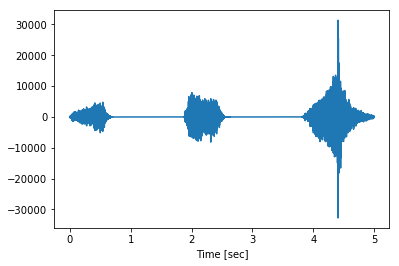

In [166]:
cat_sample = "./input/cats_dogs/" + df['test_cat'][5]
sample_rate, samples = wavfile.read(cat_sample)
frequencies, times, spectogram = signal.spectrogram(samples, sample_rate)

plt.plot(np.arange(0, len(samples)/16000, step = 1 / 16000), samples)
plt.xlabel('Time [sec]')
plt.xlabel
plt.show()

In [32]:
spectogram.shape

(129, 356)

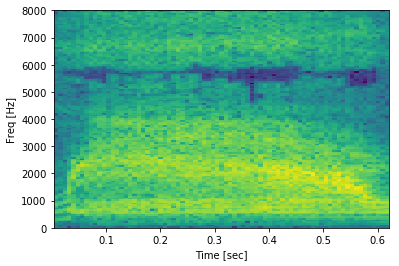

In [28]:
rate, frames = wavfile.read(cat_sample)
plt.specgram(frames[:10000], Fs=rate)
plt.xlabel('Time [sec]')
plt.ylabel('Freq [Hz]')
plt.show()

In [7]:
IPython.display.Audio("./input/cats_dogs/" + df['test_dog'][4])

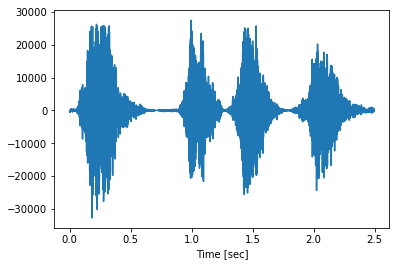

In [37]:
dog_sample = "./input/cats_dogs/" + df['test_dog'][3]
sample_rate, samples = wavfile.read(dog_sample)
frequencies, times, spectogram = signal.spectrogram(samples, sample_rate)

plt.plot(np.arange(0, len(samples)/16000, step = 1 / 16000), samples)
plt.xlabel('Time [sec]')
plt.xlabel
plt.show()

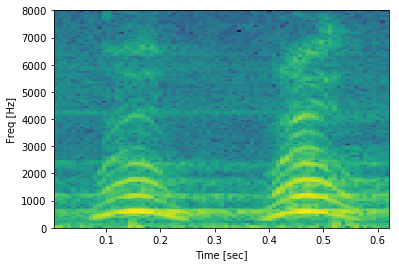

In [27]:
rate, frames = wavfile.read(dog_sample)
plt.specgram(frames[:10000], Fs=rate)
plt.xlabel('Time [sec]')
plt.ylabel('Freq [Hz]')
plt.show()

** Key takeaway here is cat meow (approx 0.6s) is typically longer than dog bark (approx 0.2s) **

### Frequency and Spectro Analysis (Dogs)

In [41]:
dataset.keys()

dict_keys(['train_cat', 'train_dog', 'test_cat', 'test_dog'])

In [161]:
dog_test = dataset['test_dog'][:50000]

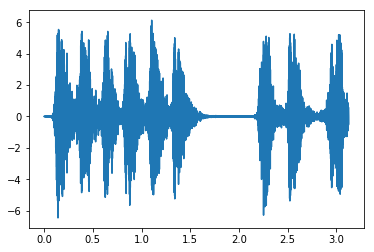

In [52]:
plt.plot(np.arange(0, len(dog_test)/16000, step = 1 / 16000), dog_test)
plt.show()

**Taking absolute values makes it easier to analyse**

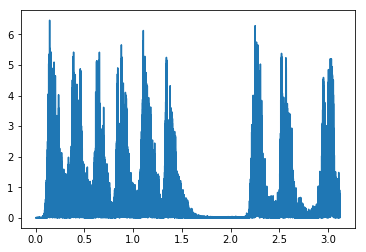

In [135]:
plt.plot(np.arange(0, len(dog_test)/16000, step = 1 / 16000), abs(dog_test))
plt.show()

**Using moving average values can help show distinct peaks to identify barks**

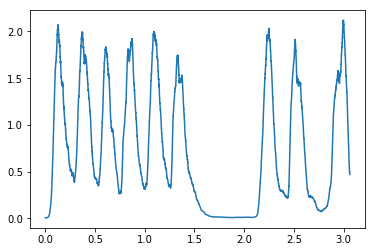

In [156]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

dog_test_ma = running_mean(abs(dog_test), 1000)
plt.plot(np.arange(0, len(dog_test_ma)/16000, step = 1 / 16000), dog_test_ma)
plt.show()

**Use 0.5 (tuneable) as activation criterion**

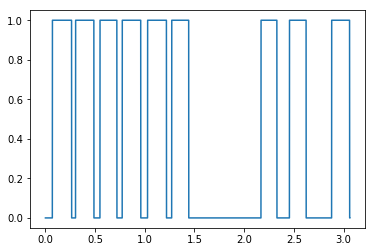

In [157]:
plt.plot(np.arange(0, len(dog_test_ma)/16000, step = 1 / 16000), (dog_test_ma > 0.5))
plt.show()

In [158]:
w = []
segment = []
prev = False
for t, i in enumerate(dog_test_ma > 0.5):
    if i == True and prev == False: ## START OF SOUND
        start = t / 16000
    if i == False and prev == True:
        end = t / 16000
        w.append((start, end))
    prev = i

In [159]:
w

[(0.0695625, 0.2630625),
 (0.3030625, 0.487375),
 (0.548625, 0.7186875),
 (0.7725, 0.9588125),
 (1.0275625, 1.2175),
 (1.2703125, 1.4415),
 (2.16875, 2.3288125),
 (2.4550625, 2.622875),
 (2.8795625, 3.0603125)]

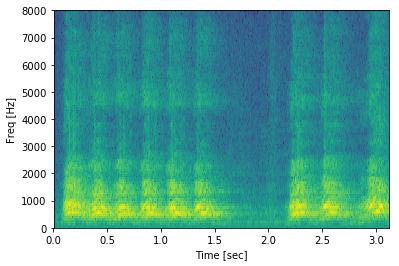

In [173]:
plt.specgram(dog_test, Fs=rate)
plt.xlabel('Time [sec]')
plt.ylabel('Freq [Hz]')
plt.show()

**Make function to verify assumed threshold with other samples**

In [181]:
def plot_spec(dir_, thres = 0.5):
    
    sample_rate, samples = wavfile.read(dir_)
    frequencies, times, spectogram = signal.spectrogram(samples, sample_rate)
    ma_spec = running_mean(abs(spectogram), 1000)
    
    f, ax = plt.subplots(2, 1) 
    ax[0].plot(np.arange(0, len(samples)/16000, step = 1 / 16000), samples)
    ax[1].plot(np.arange(0, len(ma_spec)/16000, step = 1 / 16000), (ma_spec > thres))
    
    plt.show()

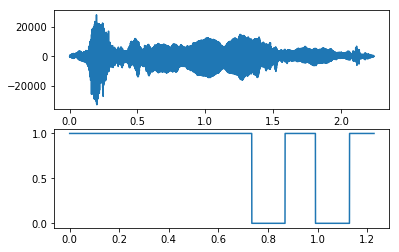

In [184]:
dog1 = "./input/cats_dogs/" + df['test_dog'][21]
plot_spec(dog1)


In [185]:
IPython.display.Audio(dog1)